In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans

import os

In [2]:
def extract_lab_features(image):
    # Identify black pixels in the original image (RGB values are all zero)
    black_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) == 0
    # Create an inverse mask for non-black pixels
    non_black_mask = ~black_mask

    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L_channel, A_channel, B_channel = cv2.split(lab_image)

    # Apply the non-black mask to each channel
    L_non_black = L_channel[non_black_mask]
    A_non_black = A_channel[non_black_mask]
    B_non_black = B_channel[non_black_mask]

    if L_non_black.size == 0:
        l_mean = 0
        a_mean = 0
        b_mean = 0
    else:
        l_mean = np.mean(L_non_black)
        a_mean = np.mean(A_non_black)
        b_mean = np.mean(B_non_black)

    return l_mean, a_mean, b_mean

In [3]:
filenames = []
l_values = []
a_values = []
b_values = []

In [4]:
base_image_path = '../Static Analysis/Data/extracted'
images = os.listdir(base_image_path)

In [5]:
for image_file in tqdm(images, desc="Parsing images"):
    # Check if the file is an image
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Construct the full image path
        full_image_path = os.path.join(base_image_path, image_file)
        # Read the image
        image = cv2.imread(full_image_path)
        if image is None:
            print(f"Error: Unable to read image at {full_image_path}")
            continue
        
        # Extract LAB features
        l_mean, a_mean, b_mean = extract_lab_features(image)
        
        # Append the data to the lists
        filenames.append(full_image_path)
        l_values.append(l_mean)
        a_values.append(a_mean)
        b_values.append(b_mean)


Parsing images: 100%|██████████| 894/894 [00:04<00:00, 219.13it/s]


In [6]:
df = pd.DataFrame({
    'filename': filenames,
    'L': l_values,
    'A': a_values,
    'B': b_values
})

In [7]:
overall_L_mean = df['L'].mean()

In [8]:
X = df[['A', 'B']]
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
print(df)

                                              filename           L  \
0    ../Static Analysis/Data/extracted\test_visuali...  124.878502   
1    ../Static Analysis/Data/extracted\test_visuali...  109.148751   
2    ../Static Analysis/Data/extracted\test_visuali...  145.036914   
3    ../Static Analysis/Data/extracted\test_visuali...  128.130234   
4    ../Static Analysis/Data/extracted\test_visuali...  119.096429   
..                                                 ...         ...   
889  ../Static Analysis/Data/extracted\test_visuali...  105.544621   
890  ../Static Analysis/Data/extracted\test_visuali...  140.506959   
891  ../Static Analysis/Data/extracted\test_visuali...   93.217493   
892  ../Static Analysis/Data/extracted\test_visuali...   95.537642   
893  ../Static Analysis/Data/extracted\test_visuali...   75.425895   

              A           B  cluster  
0    148.661143  142.332591        4  
1    140.524669  135.339649        0  
2    139.571737  130.123355        1  
3  

c:\Users\ezrat\anaconda3\envs\Project\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [9]:
df

,filename,L,A,B,cluster
0,../Static Analysis/Data/extracted\test_visuali...,124.878502,148.661143,142.332591,4
1,../Static Analysis/Data/extracted\test_visuali...,109.148751,140.524669,135.339649,0
2,../Static Analysis/Data/extracted\test_visuali...,145.036914,139.571737,130.123355,1
3,../Static Analysis/Data/extracted\test_visuali...,128.130234,151.268745,142.968346,4
4,../Static Analysis/Data/extracted\test_visuali...,119.096429,148.117542,131.313277,2
...,...,...,...,...,...
889,../Static Analysis/Data/extracted\test_visuali...,105.544621,145.444089,127.696307,1
890,../Static Analysis/Data/extracted\test_visuali...,140.506959,163.572240,165.651152,3
891,../Static Analysis/Data/extracted\test_visuali...,93.217493,145.545131,140.418153,4
892,../Static Analysis/Data/extracted\test_visuali...,95.537642,141.760242,126.670831,1


In [10]:
# Save to .csv (optional)
df.to_csv('image_clusters.csv', index=False)

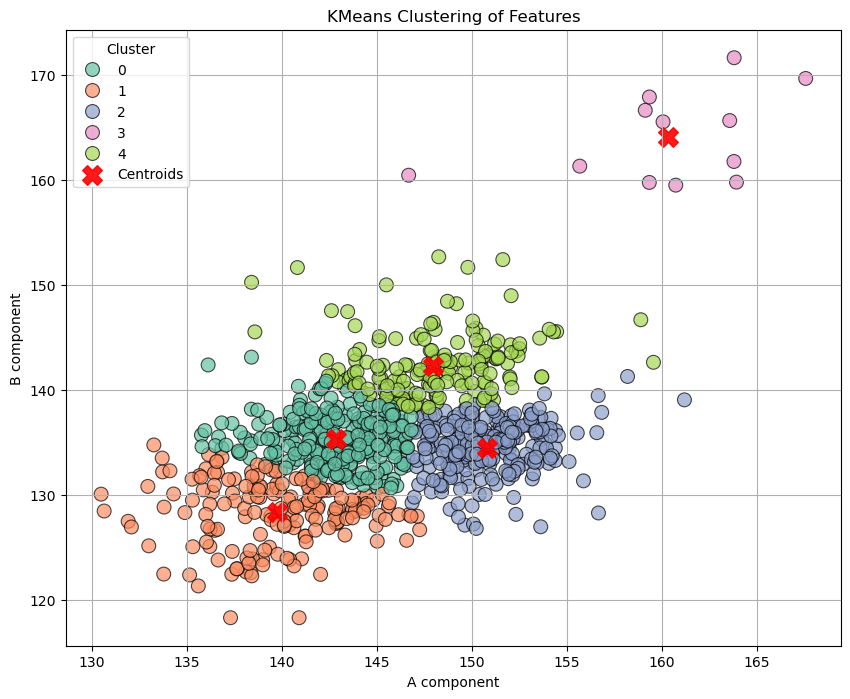

In [11]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='A',
    y='B',
    hue='cluster',
    palette='Set2',
    s=100,
    edgecolor='k',
    alpha=0.7
)

# Plot the cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    s=200,
    alpha=0.9,
    marker='X',
    label='Centroids'
)

# Customize the plot
plt.title('KMeans Clustering of Features')
plt.xlabel('A component')
plt.ylabel('B component')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

In [12]:
cluster_means = df.groupby('cluster')[['A', 'B']].mean().reset_index()
cluster_max = df.groupby('cluster')[['A', 'B']].max().reset_index()
cluster_min = df.groupby('cluster')[['A', 'B']].min().reset_index()

In [13]:
cluster_means.columns = ['cluster', 'A_mean', 'B_mean']
cluster_max.columns = ['cluster', 'A_max', 'B_max']
cluster_min.columns = ['cluster', 'A_min', 'B_min']

In [14]:
combined_cluster_df = pd.merge(cluster_means, cluster_max, on='cluster')
combined_cluster_df = pd.merge(combined_cluster_df, cluster_min, on='cluster')

In [15]:
combined_cluster_df

,cluster,A_mean,B_mean,A_max,B_max,A_min,B_min
0,0,142.842966,135.311467,146.907279,143.134544,135.758667,130.679551
1,1,139.758031,128.424714,147.250457,134.781542,130.478643,118.338146
2,2,150.816830,134.534225,161.189068,141.298085,146.849618,126.833807
3,3,160.302456,164.130137,167.572356,171.629717,146.669324,159.504905
4,4,147.969236,142.272661,159.558552,152.684258,138.397831,137.894567


In [16]:
def lab_to_rgb(l, a, b):
    # Create a 1x1 LAB image
    lab_color = np.uint8([[[l, a, b]]])
    # Convert LAB to BGR
    bgr_color = cv2.cvtColor(lab_color, cv2.COLOR_LAB2BGR)
    # Convert BGR to RGB
    rgb_color = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2RGB)
    # Flatten the array
    rgb_color = rgb_color.flatten()
    return rgb_color

In [17]:
cluster_means_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_mean'], x['B_mean'], overall_L_mean), axis=1)
cluster_max_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_max'], x['B_max'], overall_L_mean), axis=1)
cluster_min_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_min'], x['B_min'], overall_L_mean), axis=1)

combined_cluster_df['RGB_mean'] = cluster_means_rgb
combined_cluster_df['RGB_max'] = cluster_max_rgb
combined_cluster_df['RGB_min'] = cluster_min_rgb

In [18]:
combined_cluster_df

,cluster,A_mean,B_mean,A_max,B_max,A_min,B_min,RGB_mean,RGB_max,RGB_min
0,0,142.842966,135.311467,146.907279,143.134544,135.758667,130.679551,"[139, 130, 149]","[157, 129, 153]","[122, 126, 142]"
1,1,139.758031,128.424714,147.250457,134.781542,130.478643,118.338146,"[122, 131, 146]","[142, 136, 154]","[92, 127, 136]"
2,2,150.816830,134.534225,161.189068,141.298085,146.849618,126.833807,"[145, 139, 157]","[169, 146, 169]","[125, 139, 153]"
3,3,160.302456,164.130137,167.572356,171.629717,146.669324,159.504905,"[206, 128, 169]","[225, 129, 176]","[183, 117, 154]"
4,4,147.969236,142.272661,159.558552,152.684258,138.397831,137.894567,"[156, 131, 154]","[186, 136, 167]","[138, 125, 145]"


In [19]:
combined_cluster_df.to_csv('cluster_colors.csv', index=False)

In [20]:
cluster_colors = []

for _, row in cluster_means.iterrows():
    l_mean = overall_L_mean
    a_mean = row['A_mean']
    b_mean = row['B_mean']
    rgb_color = lab_to_rgb(l_mean, a_mean, b_mean)
    cluster_colors.append(rgb_color)

In [21]:
print(overall_L_mean)

119.21656100238086


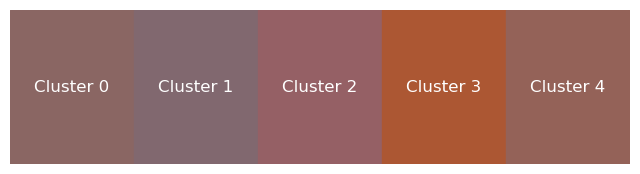

In [22]:
fig, ax = plt.subplots(figsize=(8, 2))

for i, rgb_color in enumerate(cluster_colors):
    # Normalize RGB values to [0,1] for matplotlib
    rgb_normalized = rgb_color / 255.0
    rect = plt.Rectangle((i, 0), 1, 1, color=rgb_normalized)
    ax.add_patch(rect)
    ax.text(i + 0.5, 0.5, f'Cluster {i}', va='center', ha='center', fontsize=12, color='white')

ax.set_xlim(0, len(cluster_colors))
ax.set_ylim(0, 1)
ax.axis('off')
plt.show()